In [2]:
import numpy as np
import qiskit
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib as mpl

Create data

In [3]:
n = 100
pi = np.pi
radius = np.sqrt(2 / pi)
X = 1.9 * np.random.rand(n, 2) - 1
Y = np.empty(n)
for i,x in enumerate(X):
    if np.linalg.norm(x) > radius:
        Y[i] = 1
    else:
        Y[i] = 0
        

    

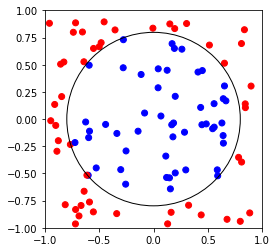

In [4]:
cmap = cm.get_cmap('bwr')
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap)
circle1 = plt.Circle([0,0], radius, color='black', fill=False)
ax.add_artist(circle1)
ax.set(xlim=[-1,1], ylim=[-1,1])
ax.set_aspect('equal', 'box')
plt.show()

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute

In [6]:
Aer.backends()


[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

In [7]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

In [8]:
dev = 'qasm_simulator'

In [9]:
def measurement(x, y, parameters, device):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(3,1)
    if y == 0:
        C.x(1)
    C.h(2)
    for l in range(layers):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 2], 0)
        
    C.cswap(2, 0, 1)
    C.h(2)
        
    C.measure([2], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend(device)

    # Execute and get counts
    sh = 1024
    result = execute(C, simulator, shots=sh).result()
    counts = result.get_counts(C)
    fidelity = 2 * counts['0'] / sh - 1
    return fidelity
    

In [10]:
def cost_function(parameters, X, Y, device):
    chi2 = 0
    for x, y in zip(X, Y):
        chi2 += (1 - measurement(x, y, parameters, device))**2
        
    return chi2 / len(Y)

In [ ]:
layers=2
from scipy.optimize import minimize
parameters = np.random.rand(5*layers)

solution = minimize(cost_function,parameters, args=(X, Y, dev), method='Powell')

solution

In [15]:
layers=2
optimal_parameters = np.random.rand(layers*5)


In [24]:
def measurement_check(x, parameters, device):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(3,1)
    C.h(2)
    for l in range(layers):
        C.u3(parameters[l,0] * x[0] + parameters[l, 1], parameters[l, 2] * x[1] + parameters[l, 3], parameters[l, 2], 0)
        
    C.cswap(2, 0, 1)
    C.h(2)
        
    C.measure([2], [0])
    C.draw()
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend(device)

    # Execute and get counts
    sh = 1024
    result = execute(C, simulator, shots=sh).result()
    counts = result.get_counts(C)
    fidelity = (2 * counts['0'] / sh - 1)
    return fidelity

In [25]:
X1 = X2 = np.linspace(-1, 1)
Z = np.empty((len(X1), len(X2)))
fig, ax = plt.subplots()
ax.set(xlim=[-1,1], ylim=[-1,1])
ax.set_aspect('equal', 'box')
for i, x1 in enumerate(X1):
    for j, x2 in enumerate(X2):
        Z[i, j] = measurement_check([x1, x2], optimal_parameters, dev)
        ax.scatter(x1, x2, c=Z[i,j, cmap=cmap, norm = mpl.colors.Normalize(vmin=0.,vmax=1.)])

[[-1.         -0.95918367 -0.91836735 ...  0.91836735  0.95918367
   1.        ]
 [-1.         -0.95918367 -0.91836735 ...  0.91836735  0.95918367
   1.        ]
 [-1.         -0.95918367 -0.91836735 ...  0.91836735  0.95918367
   1.        ]
 ...
 [-1.         -0.95918367 -0.91836735 ...  0.91836735  0.95918367
   1.        ]
 [-1.         -0.95918367 -0.91836735 ...  0.91836735  0.95918367
   1.        ]
 [-1.         -0.95918367 -0.91836735 ...  0.91836735  0.95918367
   1.        ]]


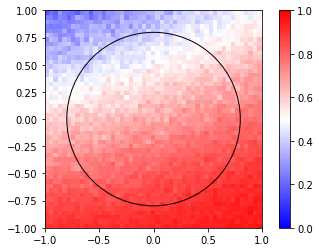

In [31]:
fig, ax = plt.subplots()
X1 = X2 = np.linspace(-1, 1)
X1, X2 = np.meshgrid(X1, X2)
cf = ax.pcolormesh(X1, X2, Z, cmap = cmap, norm = mpl.colors.Normalize(vmin=0.,vmax=1.))
circle1 = plt.Circle([0,0], radius, color='black', fill=False)
ax.add_artist(circle1)
ax.set(xlim=[-1,1], ylim=[-1,1])
ax.set_aspect('equal', 'box')
fig.colorbar(cf, ax=ax)
plt.show()

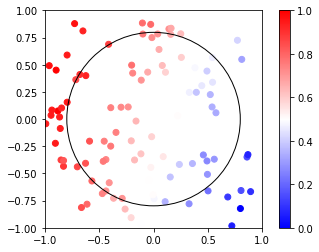

In [28]:
test = 100
X = 1.9 * np.random.rand(test, 2) - 1
Y = np.empty(test)
for i,x in enumerate(X):
    if np.linalg.norm(x) > radius:
        Y[i] = 1
    else:
        Y[i] = 0

        
F = np.empty_like(Y)
for i, x in enumerate(X):
    F[i] = measurement_check(x, optimal_parameters, dev)
    
fig, ax = plt.subplots()
X1 = X2 = np.linspace(-1, 1)
ax.scatter(X[:,0], X[:,1], c=F, cmap = cmap)#, norm = mpl.colors.Normalize(vmin=0.,vmax=1.))
circle1 = plt.Circle([0,0], radius, color='black', fill=False)
ax.add_artist(circle1)
ax.set(xlim=[-1,1], ylim=[-1,1])
ax.set_aspect('equal', 'box')
fig.colorbar(cf, ax=ax)
plt.show()

In [30]:
measurement_check([-1,1], optimal_parameters, dev)

0.9609375

In [ ]:
def checking_circuit(X, parameters, device):
    if len(parameters) % 5 != 0:
        raise ValueError('The number of parameters is not correct')
    layers = len(parameters) // 5
    parameters = parameters.reshape(layers, 5)
    C = QuantumCircuit(len(X), len(X))

    for q in range(len(X)):
        for l in range(layers):
            C.u3(parameters[l,0] * X[q,0] + parameters[l, 1], parameters[l, 2] * X[q,1] + parameters[l, 3], parameters[l, 2], q)
        C.x(q)
        
    C.measure(range(len(X)), range(len(X)))
    C.draw()
    # Select the QasmSimulator from the Aer provider
    simulator = Aer.get_backend(device)

    # Execute and get counts
    sh = 1024
    result = execute(C, simulator, shots=sh).result()
    counts = result.get_counts(C)
    return counts

In [ ]:
parameters = np.random.rand(laye)